# Searchflow

### Packages needed to run this notebook
- libmagic: ```brew install libmagic```


### ChromaDB
Don't forget to start the ChromaDB server: ```docker run -p 8000:8000 chromadb/chroma```

In [ ]:
# Load packages from the src directory
import sys
sys.path.append('../src')

from dotenv import load_dotenv
load_dotenv()

from vectrix_graphs import ExtractDocuments, setup_logger, ExtractMetaData

### Extracting chunks of data from a document

In [ ]:
# Extract chunks of data from a document
extract = ExtractDocuments(
    logger=setup_logger(name="Files", level="INFO"),
    )

result = extract.extract(file_path="files/attention_is_all_you_need.pdf", )

# Add additional metadata using a NER-pipeline
ner = ExtractMetaData(
    logger=setup_logger(name="ExtractMetaData", level="INFO",),
    model="llama3.1-8B" # Options are gpt-4o-mini, llama3.1-8B , llama3.1-70B
    )
result_with_metadata = ner.extract(result, source="uploaded_file")


### Adding the documents to a vector database (Chroma)

For this demo, the vector database will be saved locally on disk, restarting the container will delete the database.
I prefer using the cosine distance instead of the default squared L2 distance, we pass this using the `hnsw:space` metadata.

$$
d = 1.0 - \frac{\sum(A_i \times B_i)}{\sqrt{\sum(A_i^2) \cdot \sum(B_i^2)}}
$$

We use Ollama to calculate the embeddings locally with BGE-M3, since over a 100 langues are supported this is ideal for embedding Arabic documents.

BGE-M3 is based on the XLM-RoBERTa architecture and is distinguished for its versatility in Multi-Functionality, Multi-Linguality, and Multi-Granularity:

- Multi-Functionality: It can simultaneously perform the three common retrieval functionalities of embedding model: dense retrieval, multi-vector retrieval, and sparse retrieval.
- Multi-Linguality: It can support more than 100 working languages.
- Multi-Granularity: It is able to process inputs of different granularities, spanning from short sentences to long documents of up to 8192 tokens.

> ℹ️ So all embeddings will be calculated locally ℹ️


In [ ]:
from vectrix_graphs import VectorDB
import pathlib
import os

vector_db = VectorDB(logger=setup_logger(name="VectorDB", level="INFO"))

In [7]:
vector_db.add_documents(result_with_metadata)

In [ ]:
# Now let's query the vector database
vector_db.similarity_search(
    query="Explain how decoder architecture is used in the paper?",
    k=3
    )

## Asking questions to the Graph
 Let's now ask questions using the LangGraph workflow

### Example 1: Using closed source LLMs


In [ ]:
# Load packages from the src directory
import sys
sys.path.append('../src')

from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from vectrix_graphs import default_flow
from vectrix_graphs.graphs.utils.stream_processor import StreamProcessor
import warnings
from vectrix_graphs.logger import setup_logger

# Display the graph
display(Image(default_flow.get_graph().draw_mermaid_png()))

stream = StreamProcessor(graph=default_flow, logger=setup_logger(name="StreamProcessor", level="INFO"))

# Set the input message
input = [HumanMessage(content="Explain how decoder architecture is used in the paper?")]

# Run the stream and print the chunks
async for chunk in stream.process_stream(messages=input):
    print(chunk)

### Example 2: Using open-source LLMs that can be self-hosted

2024-10-24 16:21:48,107 - VectorDB - WARNING - Demo collection already exists
2024-10-24 16:21:48,215 - VectorDB - WARNING - Demo collection already exists


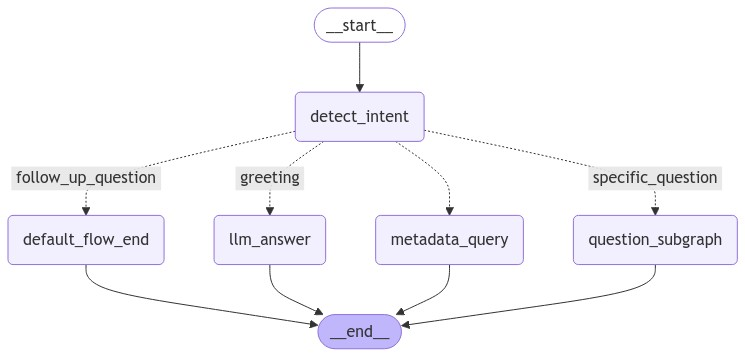

<answer_markdown>
The decoder architecture in the paper is implemented as a crucial component of the Transformer model's encoder-decoder structure<sup><a href="#ref1">¹</a></sup>. Here are the key aspects of the decoder architecture:

1. Structure and Layers:
- The decoder consists of a stack of N=6 identical layers<sup><a href="#ref2">²</a></sup>
- Each decoder layer contains three sub-layers:
  - Two sub-layers similar to the encoder
  - An additional third sub-layer that performs multi-head attention over the encoder stack output<sup><a href="#ref2">²</a></sup>

2. Key Features:
- Employs residual connections around each sub-layer
- Uses layer normalization after each sub-layer<sup><a href="#ref2">²</a></sup>
- Includes a modified self-attention sub-layer with position masking<sup><a href="#ref2">²</a></sup>

3. Auto-regressive Properties:
- The decoder operates in an auto-regressive manner, consuming previously generated symbols as input when generating the next symbol<sup><a href=

ValidationError: 2 validation errors for AIMessage
content.str
  Input should be a valid string [type=string_type, input_value={'answer_markdown': "\nTh...oder-decoder structure"}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type
content.list[union[str,dict[any,any]]]
  Input should be a valid list [type=list_type, input_value={'answer_markdown': "\nTh...oder-decoder structure"}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type

In [1]:
# Load packages from the src directory
import sys
sys.path.append('../src')

from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from vectrix_graphs import local_slm_demo
from vectrix_graphs.graphs.utils.stream_processor import StreamProcessor
from vectrix_graphs.logger import setup_logger

# Display the graph
display(Image(local_slm_demo.get_graph().draw_mermaid_png()))

stream = StreamProcessor(graph=local_slm_demo, logger=setup_logger(name="StreamProcessor", level="INFO"))

# Set the input message
input = [HumanMessage(content="Explain how decoder architecture is used in the paper?")]

# Run the stream and print the chunks
async for chunk in stream.process_stream(messages=input):
    print(chunk)